## Testing Seq 2 Seq Modeling
Reference: 
- https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
- https://github.com/aravindpai/How-to-build-own-text-summarizer-using-deep-learning/blob/master/How_to_build_own_text_summarizer_using_deep_learning.ipynb

Used Dataset:
- Amazon Reviews

In [1]:
# Importing libraries
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from attention import AttentionLayer

Using TensorFlow backend.


In [2]:
data=pd.read_csv("./data/Reviews.csv",nrows=100000)

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [4]:
data.drop_duplicates(subset=['Text'],inplace=True) #dropping duplicates
data.dropna(axis=0,inplace=True) #dropping na

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      88421 non-null  int64 
 1   ProductId               88421 non-null  object
 2   UserId                  88421 non-null  object
 3   ProfileName             88421 non-null  object
 4   HelpfulnessNumerator    88421 non-null  int64 
 5   HelpfulnessDenominator  88421 non-null  int64 
 6   Score                   88421 non-null  int64 
 7   Time                    88421 non-null  int64 
 8   Summary                 88421 non-null  object
 9   Text                    88421 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

## Preprocessing
- Convert everything to lowercase
- Remove HTML tags
- Contraction mapping
- Remove (‘s)
- Remove any text inside the parenthesis ( )
- Eliminate punctuations and special characters
- Remove stopwords
- Remove short words

In [7]:
# import nltk
# nltk.download('stopwords')

In [8]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [9]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [10]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [11]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [12]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [13]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [14]:
# Drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

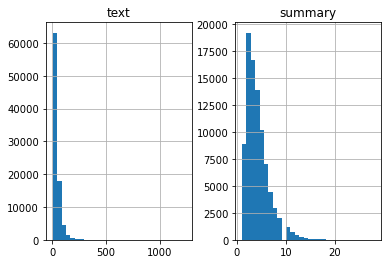

In [15]:
# Understand distribution of words to fix max_length for summary and review
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [16]:
# Understand proportion of length of summaries < 8
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


In [17]:
max_text_len=30
max_summary_len=8

In [18]:
# Select reviews & summaries with determined max_length
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [19]:
# Apply unique START and END token
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [20]:
# 90% Training data and 10% holdout set
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [21]:
# Preparing Tokenizer for reviews on training data
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [22]:
# Rarewords and coverage
# -- threshold is 4 => Below 4 is rareword
thresh=4

cnt=0 # no. of rare words below threshold
tot_cnt=0 # size of vocabulary (unique words in text)
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.12339930151339
Total Coverage of rare words: 2.953684513790566


In [23]:
# Tokenizer with Top most common words
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # tot_cnt - cnt gives me the top most common words
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [24]:
x_voc

8440

## Summary Tokenizer 

In [25]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.12740675541863
Total Coverage of rare words: 5.3921899389571895


In [26]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [27]:
# Check whether word count with start token is == length of training data
y_tokenizer.word_counts['sostok'],len(y_tr)

(42453, 42453)

In [28]:
# Delete Rows with only START & END token
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

## Model Building
- Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep
- Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only
- Initial State: This is used to initialize the internal states of the LSTM for the first timestep
- Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

In [30]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Loss function: sparse categorical cross-entropy

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [32]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=15,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 41346 samples, validate on 4588 samples
Epoch 1/15
41346/41346 [==============================] - 612s 15ms/sample - loss: 3.1990 - val_loss: 2.7456
Epoch 2/15
41346/41346 [==============================] - 585s 14ms/sample - loss: 2.6976 - val_loss: 2.6343
Epoch 3/15
41346/41346 [==============================] - 577s 14ms/sample - loss: 2.5919 - val_loss: 2.5431
Epoch 4/15
41346/41346 [==============================] - 578s 14ms/sample - loss: 2.5159 - val_loss: 2.4924
Epoch 5/15
41346/41346 [==============================] - 567s 14ms/sample - loss: 2.4451 - val_loss: 2.4131
Epoch 6/15
41346/41346 [==============================] - 579s 14ms/sample - loss: 2.3715 - val_loss: 2.3534
Epoch 7/15
41346/41346 [==============================] - 583s 14ms/sample - loss: 2.2991 - val_loss: 2.3007
Epoch 8/15
41346/41346 [==============================] - 562s 14ms/sample - loss: 2.2317 - val_loss: 2.2484
Epoch 9/15
41346/41346 [==============================] - 576s 14ms/sample - lo

In [41]:
model.input

[<tf.Tensor 'input_1:0' shape=(None, 30) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, None) dtype=float32>]

## Understand diagnostic plot

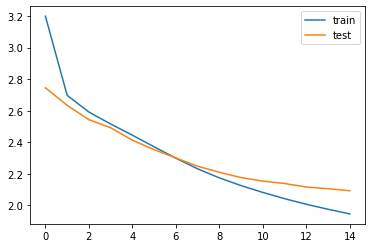

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
# Build dictionary to convert index into words (target & source vocab)
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [36]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [42]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/

## Saving Models
encoder_model.save("./encoder_model1.h5")
decoder_model.save("./decoder_model1.h5")

## Loading Model
# encoder_model = load_model("./encoder_model1.h5", custom_objects={'AttentionLayer': AttentionLayer})
# decoder_model = load_model("./decoder_model1.h5", custom_objects={'AttentionLayer': AttentionLayer})

## Inference process
1. Encode the entire input sequence and initialize the decoder with internal states of the encoder
2. Pass <start> token as an input to the decoder
3. Run the decoder for one timestep with the internal states
4. The output will be the probability for the next word. The word with the maximum probability will be selected
5. Pass the sampled word as an input to the decoder in the next timestep and update the internal states with the current time step
6. Repeat steps 3 – 5 until we generate <end> token or hit the maximum length of the target sequence

In [37]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [38]:
# Convert int sequence --> word sequence
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [39]:
for i in range(0,20):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: gave caffeine shakes heart anxiety attack plus tastes unbelievably bad stick coffee tea soda thanks 
Original summary: hour 
Predicted summary:  great tea


Review: got great course good belgian chocolates better 
Original summary: would like to give it stars but 
Predicted summary:  great


Review: one best flavored coffees tried usually like flavored coffees one great serve company love 
Original summary: delicious 
Predicted summary:  great coffee


Review: salt separate area pain makes hard regulate salt putting like salt go ahead get product 
Original summary: tastes ok packaging 
Predicted summary:  great salt


Review: really like product super easy order online delivered much cheaper buying gas station stocking good long drives 
Original summary: turkey jerky is great 
Predicted summary:  great


Review: best salad dressing delivered promptly quantities last vidalia onion dressing compares made oak hill farms sometimes find costco order front door want even orders cut s